In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def build_state(features):
    return int("".join(map(lambda feature: str(int(feature)), features)))

def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [3]:
class FeatureTransformer:
    def __init__(self):
        # Note: to make this better you could look at how often each bin was
        # actually used while running the script.
        # It's not clear from the high/low values nor sample() what values
        # we really expect to get.
        self.cart_position_bins = np.linspace(-2.4, 2.4, 9)
        self.cart_velocity_bins = np.linspace(-2, 2, 9) # (-inf, inf) (I did not check that these were good values)
        self.pole_angle_bins = np.linspace(-0.4, 0.4, 9)
        self.pole_velocity_bins = np.linspace(-3.5, 3.5, 9) # (-inf, inf) (I did not check that these were good values)

    def transform(self, observation):
        # returns an int
        cart_pos, cart_vel, pole_angle, pole_vel = observation
        return build_state([
          to_bin(cart_pos, self.cart_position_bins),
          to_bin(cart_vel, self.cart_velocity_bins),
          to_bin(pole_angle, self.pole_angle_bins),
          to_bin(pole_vel, self.pole_velocity_bins),
        ])

In [4]:
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.feature_transformer = feature_transformer

        num_states = 10**env.observation_space.shape[0]
        num_actions = env.action_space.n
        self.Q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))

    def predict(self, s):
        x = self.feature_transformer.transform(s)
        return self.Q[x]

    def update(self, s, a, G):
        x = self.feature_transformer.transform(s)
        self.Q[x,a] += 1e-2*(G - self.Q[x,a])

    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            p = self.predict(s)
            return np.argmax(p)

In [5]:
def play_one(model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done and iters < 10000:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)

        totalreward += reward

        if done and iters < 199:
            reward = -300

        # update the model
        G = reward + gamma*np.max(model.predict(observation))
        model.update(prev_observation, action, G)

        iters += 1

    return totalreward

In [10]:
def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")

In [7]:
env = gym.make('CartPole-v0')
ft = FeatureTransformer()
model = Model(env, ft)
gamma = 0.9


N = 10000
totalrewards = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
        print("episode:", n, "total reward:", totalreward, "eps:", eps)
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

episode: 0 total reward: 37.0 eps: 1.0
episode: 100 total reward: 24.0 eps: 0.09950371902099892
episode: 200 total reward: 126.0 eps: 0.07053456158585983
episode: 300 total reward: 70.0 eps: 0.0576390417704235
episode: 400 total reward: 20.0 eps: 0.04993761694389223
episode: 500 total reward: 50.0 eps: 0.04467670516087703
episode: 600 total reward: 106.0 eps: 0.04079085082240021
episode: 700 total reward: 10.0 eps: 0.0377694787300249
episode: 800 total reward: 46.0 eps: 0.03533326266687867
episode: 900 total reward: 128.0 eps: 0.03331483023263848
episode: 1000 total reward: 187.0 eps: 0.0316069770620507
episode: 1100 total reward: 51.0 eps: 0.03013743873394561
episode: 1200 total reward: 114.0 eps: 0.028855492841238062
episode: 1300 total reward: 175.0 eps: 0.027724348650071385
episode: 1400 total reward: 48.0 eps: 0.02671658425726324
episode: 1500 total reward: 146.0 eps: 0.025811286645983367
episode: 1600 total reward: 151.0 eps: 0.02499219116020307
episode: 1700 total reward: 125.0 

In [ ]:

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

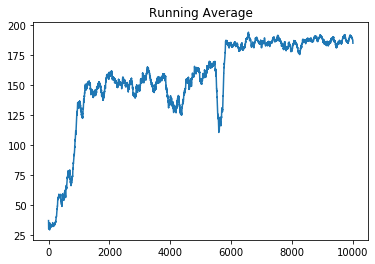

In [11]:
plot_running_avg(totalrewards)

In [19]:
GAMMA = 0.9
ALPHA = 0.01
N_EPISODES = 10000

In [20]:
def get_action(env, t, s, q):
    e = np.random.random()
    if e < 1 / (t + 1):
        return env.action_space.sample()
    return np.argmax(q[s])

In [21]:
def play_one_episode(env, t, q, tr):
    done = False
    episode_length = 0
    s = env.reset()
    s = tr.transform(s)
    while not done:
        episode_length += 1
        a = get_action(env, t, s, q)
        s1, r, done, _ = env.step(a)
        s1 = tr.transform(s1)
        
        if done and episode_length < 199:
            r = -300
        
        if done:
            target = r
        else:
            target = r + GAMMA * np.max(q[s1])
            
        q[s][a] += ALPHA * (target - q[s][a])
        
        s = s1
    
    return episode_length        

In [27]:
env = gym.make('CartPole-v0')
num_states = 10**env.observation_space.shape[0]
num_actions = env.action_space.n
q = np.random.uniform(low=-1, high=1, size=(num_states, num_actions))

tr = FeatureTransformer()
episode_lengths = np.empty(N_EPISODES)

for episode in range(N_EPISODES):
    episode_length = play_one_episode(env, episode, q, tr)
    if episode % 100 == 0:
        print(episode, episode_length)
    episode_lengths[episode] = episode_length

0 21
100 20
200 81
300 38
400 103
500 123
600 67
700 132
800 92
900 124
1000 118
1100 156
1200 114
1300 159
1400 101
1500 104
1600 128
1700 127
1800 148
1900 105
2000 113
2100 122
2200 124
2300 184
2400 164
2500 199
2600 188
2700 116
2800 200
2900 87
3000 99
3100 105
3200 176
3300 58
3400 107
3500 107
3600 110
3700 119
3800 96
3900 136
4000 143
4100 200
4200 122
4300 117
4400 200
4500 144
4600 135
4700 153
4800 200
4900 134
5000 105
5100 176
5200 130
5300 112
5400 125
5500 185
5600 176
5700 105
5800 115
5900 91
6000 200
6100 141
6200 107
6300 164
6400 186
6500 111
6600 145
6700 100
6800 92
6900 186
7000 109
7100 109
7200 193
7300 200
7400 131
7500 104
7600 110
7700 200
7800 112
7900 192
8000 110
8100 127
8200 100
8300 140
8400 103
8500 200
8600 200
8700 111
8800 129
8900 171
9000 103
9100 134
9200 180
9300 153
9400 99
9500 196
9600 148
9700 110
9800 149
9900 165


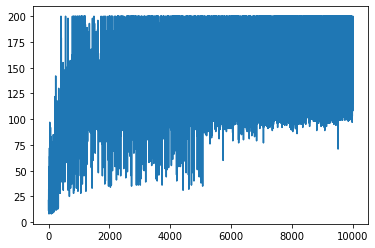

In [28]:
plt.plot(episode_lengths)

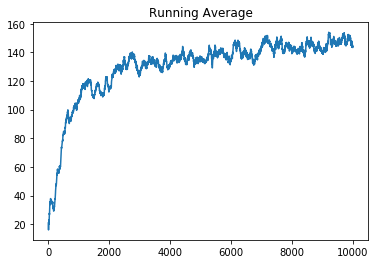

In [29]:
plot_running_avg(episode_lengths)